# EIT-CEM Foward Problem

In [1]:
#Auxiliar modules
from dolfin import*
from mshr import*
import numpy as np
from fenics import*import 
import matplotlib.pyplot as plt
import time
import pandas as pd
%matplotlib inline

#My modules
from module1_mesh import *
from module2_foward import *
from module3_inverse import *
from module4_auxiliar import *

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed',)).History will not be written to the database.


In [2]:
"Electrodes and Mesh"
ele_pos=electrodes_position(L=16, per_cober=0.5, rotate=0)
mesh_direct=MyMesh(r=1, n=20, n_in=80, n_out=60, electrodes_obj=ele_pos)
mesh_inverse=MyMesh(r=1, n=10, n_in=8, n_out=3, electrodes_obj=ele_pos)

#### Malhas

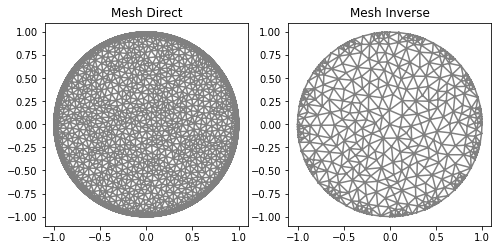

In [3]:
plt.figure(figsize=(8, 8))
plt.subplot(1,2,1)
plot(mesh_direct, title="Mesh Direct");
plt.subplot(1,2,2)
plot(mesh_inverse, title="Mesh Inverse");

## Problema Direto

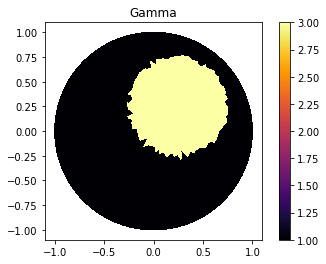

In [4]:
"Gamma function"
ValuesCells0=GammaCircle(mesh_direct,3.0,1.0,0.50, 0.25, 0.25);
gamma0=CellFunction(mesh_direct, values=ValuesCells0)

"Plot"
V_DG=FiniteElement('DG',mesh_direct.ufl_cell(),0)
gamma_direct=plot_figure(mesh_direct, V_DG, gamma0, name="Gamma");

### Foward Problem

In [5]:
"Foward Problem"
VD=FiniteElement('CG',mesh_direct.ufl_cell(),1) #Lagrange pol. degree 1
L=16                                            #Electrodes number
l=16                                            #Measurements number.
z=np.ones(L)*0.025                              #Impedance
I_all=current_method(L,l, method=2, value=1)    #Current pattern

#Solver
FowardObject=FowardProblem(mesh_direct,  ele_pos,  z)
list_u0, list_U0 = FowardObject.solve_foward(VD, gamma0, I_all, l)
list_U0 = FowardObject.sol_asarray()

256


### Solver

### Plot Noise

In [6]:
"Getting noised solution"
noise_level=0.01 #0.5%
noise_type='uniform'
if noise_level>1E-10: list_U0_noised = FowardObject.add_noise(noise_level, noise_type, seed=1)

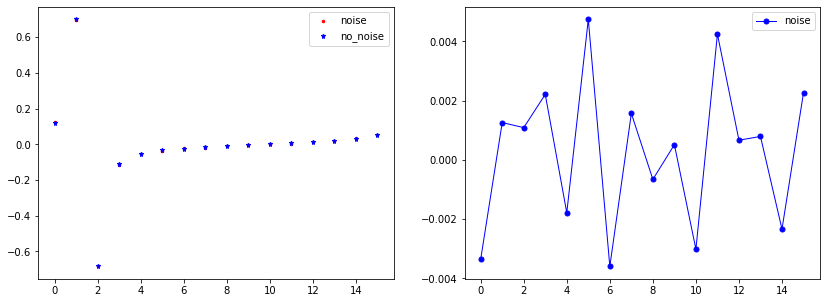

In [7]:
"Plot electrodes noise."
index=1 #Index in array

if noise_level>1E-5:
    vec_U0_noise=list_U0_noised[index*L:(index+1)*L]
    vec_U0=list_U0[index*L:(index+1)*L]
    x=range(len(vec_U0_noise))

    plt.figure(figsize=(14, 5),)
    plt.subplot(1,2,1)
    plt.plot(x, vec_U0_noise, linewidth=0,  marker='.', markersize=5, label="noise", color='red');
    plt.plot(x, vec_U0, linewidth=0,  marker='*', markersize=5, label="no_noise", color="blue");
    plt.legend()
   
    plt.subplot(1,2,2)
    plt.plot(x, vec_U0-vec_U0_noise, linewidth=1,  marker='.', markersize=10, label="noise", color="blue");
    plt.legend()
    
    plt.show()

### Solver Parameters

In [24]:
"Object"
InverseObject=InverseProblem(mesh_inverse,  ele_pos,  z, list_U0_noised, I_all, l)

"Solver Parameters"
InverseObject.set_solverconfig(step_limit=100)
InverseObject.set_NewtonParameters(mu_i=0.75, mumax=0.999, nu=0.99, R=0.75)
#InverseObject.set_InnerParameters(inner_method='Landweber', land_a=20)
InverseObject.set_InnerParameters(inner_method='ME', ME_reg=5E-3)
#InverseObject.set_InnerParameters(inner_method='CG')
#InverseObject.set_InnerParameters(inner_method='LM', LM_c0=0.95, LM0_q=1)
#InverseObject.set_InnerParameters(inner_method='Tikhonov', LM_Tik=0.95, Tik_q=1)

"Noise Parameters"
tau=1.1
InverseObject.set_NoiseParameters(tau=tau, noise_level=0.01)
print(f"Discrepance stop {tau*noise_level*100}% residue")

"Noise Parameters"
InverseObject.set_answer(gamma0, mesh_direct)
InverseObject.weight_value=False
#MyCellsgamma_k=np.ones(mesh_inverse.num_cells())*2.0
#InverseObject.set_firstguess(MyCellsgamma_k)

Discrepance stop 1.1% residue


In [25]:
#Solver
InverseObject.solve_inverse()

Error (%)= 60.792819594804804 Residue (%)= 13.848008779014679  step: 0 Inner step:  0
mu_n 0.75
Error (%)= 58.873793233535466 Residue (%)= 10.10304899471439  step: 1 Inner step:  2
mu_n 0.75
Error (%)= 53.802853093412004 Residue (%)= 6.852604022869893  step: 2 Inner step:  3
mu_n 0.8325
Error (%)= 50.28935874287922 Residue (%)= 5.18476538202439  step: 3 Inner step:  2
mu_n 0.74925
Error (%)= 46.81491820372219 Residue (%)= 3.9073029089802085  step: 4 Inner step:  4
mu_n 0.74925
Error (%)= 43.55128217207813 Residue (%)= 2.841360862914576  step: 5 Inner step:  7
mu_n 0.8558575714285714
Error (%)= 41.53900050365419 Residue (%)= 2.3685338151948585  step: 6 Inner step:  6
mu_n 0.8310019995
Error (%)= 38.28201199075345 Residue (%)= 1.801903537635367  step: 7 Inner step:  13
mu_n 0.8218692875254949
Error (%)= 35.471917364518895 Residue (%)= 1.4753519013511665  step: 8 Inner step:  20
mu_n 0.88333082185468
Error (%)= 31.921136205493255 Residue (%)= 1.3044290541466936  step: 9 Inner step:  45
mu

In [26]:
"Getting the result"
gamma_k=InverseObject.gamma_k
list_U=InverseObject.list_U

"Getting data_summary"
innerstep_vec=InverseObject.innerstep_vec
res_vec=InverseObject.res_vec
mun_vec=InverseObject.mun_vec
error_vec=InverseObject.error_vec

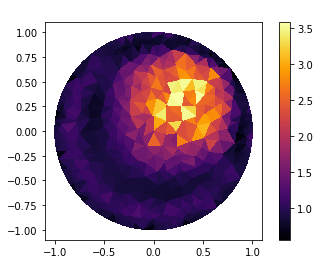

In [27]:
"Plot result"
V_DG=FiniteElement('DG',mesh_inverse.ufl_cell(),0)
gamma_k=plot_figure(mesh_inverse, V_DG, gamma_k, name=" ");

jet


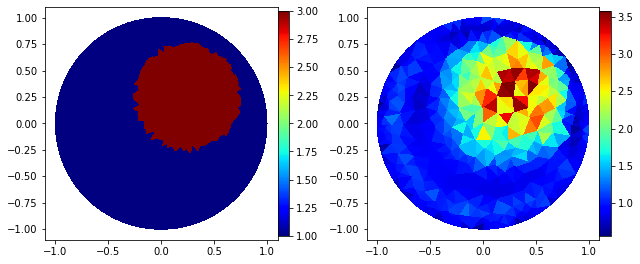

In [34]:
"Fancy plot"
cmap=['Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'icefire', 'icefire_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'mako', 'mako_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'rocket', 'rocket_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'vlag', 'vlag_r', 'winter', 'winter_r']
cmap=cmap[126]#51 63 90 94 126 164 111
#cmap='inferno'
#print(cmap)
fig=plt.figure(figsize=(9, 9))
plt.subplot(1,2,1);
p=plot(gamma_direct);
p.set_cmap(cmap)
plt.colorbar(p,fraction=0.046, pad=0.0);

plt.subplot(1,2,2);
p=plot(gamma_k);
p.set_cmap(cmap);
plt.colorbar(p,fraction=0.046, pad=0.0);
fig.tight_layout()
print(cmap)

#### Potencial in first measurement.

In [29]:
"Checking results"
vec_U_plot=np.vstack((list_U0, list_U))
data=pd.DataFrame(vec_U_plot[:,0:16].T)
experiments=["Expected", "Calculed"]
data.columns = experiments
data

,Expected,Calculed
0,0.751763,0.754028
1,-0.696700,-0.694623
2,-0.115757,-0.116598
3,-0.062609,-0.065001
4,-0.045550,-0.047037
5,-0.035559,-0.036300
6,-0.028117,-0.028568
7,-0.021773,-0.021899
8,-0.015809,-0.015562
9,-0.009689,-0.009135


#### Plot error

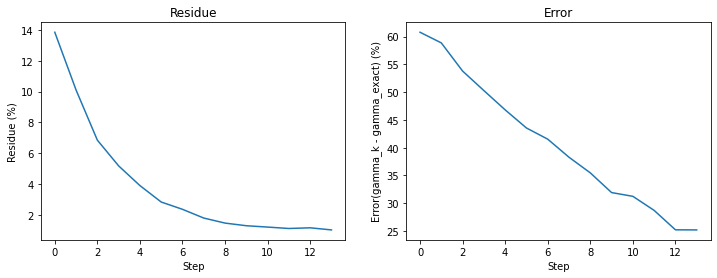

In [33]:
plt.figure(figsize=(12, 4));
"Residue Plot"
plt.subplot(1,2,1)
plt.ylabel('Residue (%)');
plt.xlabel('Step');
plt.title('Residue');
plt.plot(range(0,len(res_vec)), res_vec);

"Error plot"
plt.subplot(1,2,2)
plt.ylabel('Error(gamma_k - gamma_exact) (%)');
plt.xlabel('Step');
plt.title('Error');
plt.plot(range(0,len(error_vec)), error_vec);

#### Summary Data

In [31]:
summary_data=np.vstack((error_vec, res_vec, innerstep_vec, mun_vec))
data=pd.DataFrame(summary_data.T)
experiments=["Error (%)", "Residue (%) ", "Inner Step", "mu_n"]
data.columns = experiments
data

,Error (%),Residue (%),Inner Step,mu_n
0,60.792820,13.848009,0.0,0.000000
1,58.873793,10.103049,2.0,0.750000
2,53.802853,6.852604,3.0,0.750000
3,50.289359,5.184765,2.0,0.832500
4,46.814918,3.907303,4.0,0.749250
5,43.551282,2.841361,7.0,0.749250
6,41.539001,2.368534,6.0,0.855858
7,38.282012,1.801904,13.0,0.831002
8,35.471917,1.475352,20.0,0.821869
9,31.921136,1.304429,45.0,0.883331
